In this notebook some image processing techniques are avlued for enhancing the PIV results. The first part is dedicated to proper contrast stretching techniques, the second to correction (removal) of areas clearly affected by an error (such as flash mirrored images).

In [1]:
# Import necessary modules
from openpiv import tools, pyprocess, validation, filters, scaling 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
from math import *
import imageio


In [2]:
# Set variables

folder = '/home/edo20/PIV'
technique = 'standard'
# Camera
resolution = (992,1004) #pixel
physical_window = (45,45) # m
pixel_depth = 8 # bit
dynamic_range = 2**pixel_depth # levels
scaling_factor = 1/(np.mean(physical_window)/np.mean(resolution)) # m/pixel
image_number = '001'

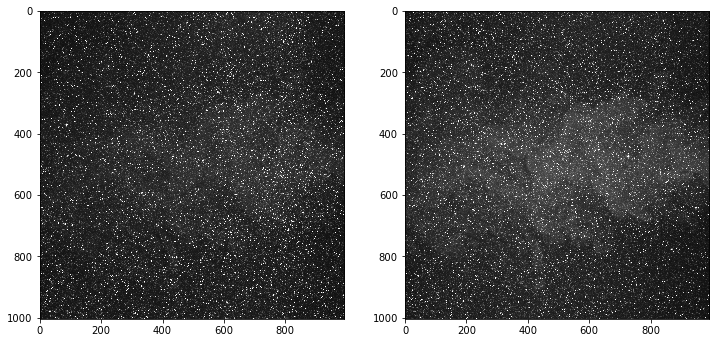

In [3]:
# Load and plot images to work on
frame_a  = tools.imread( folder + '/Images/A' + image_number + 'a.tif' )
frame_b  = tools.imread( folder + '/Images/A' + image_number + 'b.tif' )
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

# Standard contrast stretching


In [4]:
# Image equalization
def image_equalization(frame,dynamic_range = 255, plot = 0):
    frame = np.array(frame)
    # Histogram and cdf of the original image
    hist,bins = np.histogram(frame.flatten(),dynamic_range,[0,dynamic_range])
    cdf = hist.cumsum()
    cdf_normalized = cdf * hist.max()/ cdf.max()
    
    #Image equalization
    cdf_m = np.ma.masked_equal(cdf,0)
    cdf_m = (cdf_m - cdf_m.min())*dynamic_range/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint8')
    frameEQ = cdf[frame]    
    
    # Histogram and cdf of the equalized image
    frameEQ = np.array(frameEQ)
    histEQ,binsEQ = np.histogram(frameEQ.flatten(),dynamic_range,[0,dynamic_range])
    cdfEQ = histEQ.cumsum()
    cdf_normalizedEQ = cdfEQ * histEQ.max()/ cdfEQ.max()
    
    # Plot
    if plot:
        # Oriinal image
        ax1 = plt.subplot(1,2,1)
        ax1.plot(cdf_normalized, color = 'b')
        ax1.hist(frame.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax1.set_xlim([0,dynamic_range])
        ax1.legend(('cdf','histogram'), loc = 'upper left')
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.plot(cdf_normalizedEQ, color = 'b')
        ax2.hist(frameEQ.flatten(),dynamic_range,[0,dynamic_range], color = 'r')
        ax2.set_xlim([0,dynamic_range])
        ax2.legend(('cdf','histogram'), loc = 'upper left')
        ax2.set_title('Equalized image')
        plt.show()
        
    return frameEQ

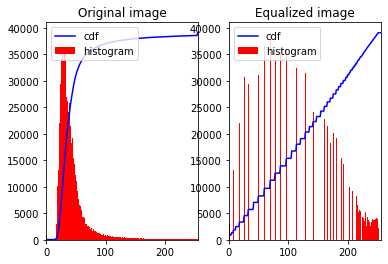

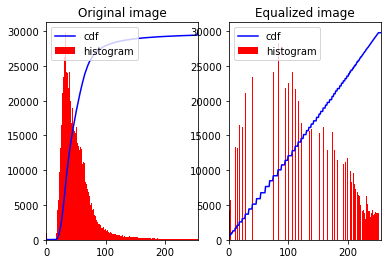

In [5]:
frame_a = image_equalization(frame_a,dynamic_range,plot=1)
frame_b = image_equalization(frame_b,dynamic_range,plot=1)

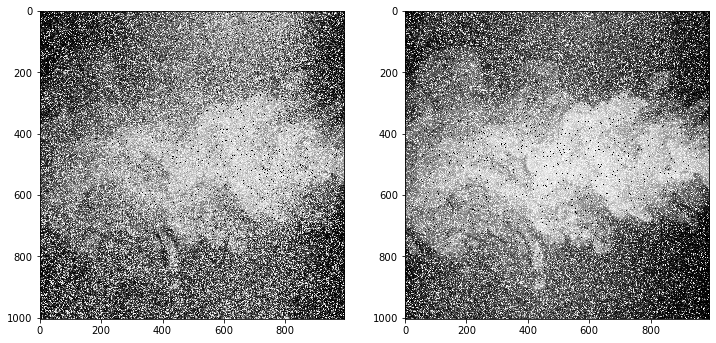

In [6]:
# Plot equalized images
fig,ax = plt.subplots(1,2,figsize=(12,10))
ax[0].imshow(frame_a,cmap=plt.cm.gray)
ax[1].imshow(frame_b,cmap=plt.cm.gray)

# MinMax filtering

Definition of morphological operations

In [7]:
# Basic morphological operations
def dilate(frame, kernel):
    shape = np.shape(frame)
    shapek = np.shape(kernel)
    #cycle on the figure
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            value = 0
            # cycle on the kernel
            for k in range(0,shapek[0]):
                for l in range(0,shapek[1]):
                    if kernel[k,l] == 1:
                        posx = i-k
                        posx = min(posx,shape[0])
                        posx = max(posx,0)
                        posy = j-l
                        posy = min(posx,shape[1])
                        posy = max(posx,0)
                        value = max(frame[posx,posy])
            
            # Update the value of the frame
            frame[i,j] = value
            
    return frame


def erode(frame, kernel):
    shape = np.shape(frame)
    shapek = np.shape(kernel)
    #cycle on the figure
    for i in range(0,shape[0]):
        for j in range(0,shape[1]):
            value = 0
            # cycle on the kernel
            for k in range(0,shapek[0]):
                for l in range(0,shapek[1]):
                    if kernel[k,l] == 1:
                        posx = i-k
                        posx = min(posx,shape[0])
                        posx = max(posx,0)
                        posy = j-l
                        posy = min(posx,shape[1])
                        posy = max(posx,0)
                        value = max(frame[posx,posy])
            
            # Update the value of the frame
            frame[i,j] = value
            
    return frame
# Kernels
def cross(size, print_out = False):
    if (size % 2) != 1:
        print('Choose an odd size please')
        
    out = np.zeros((size,size))
    center = np.floor(size/2)
    center = int(center)
    out[center,:] = np.ones(size)
    out[:,center] = np.ones(size)
    
    if print_out:
        plt.imshow(out)
    
    return out

def disk(radius, print_out = False):
    # Not working
    if (size % 2) != 1:
        print('Choose an odd size please')
    out = np.zeros((radius,radius))
    for i in range(0,radius):
        for j in range(0,radius):
            k = abs(i - floor(radius/2))
            l = abs(j - floor(radius/2))
            out[i,j] = ((k*k+l*l) < radius*radius)
    
    if print_out:
        plt.imshow(out)
        
    return out

# Filters
def minmax(frame, kernel):
    erosion = erode(frame,kernel)
    dilation = dilate(frame, kernel)
    out = (frame - erosion) / (dilation - erosion)
    
    return out


In [8]:
# # Test cell
# size = 9
# out = np.zeros((size,size))
# center = np.floor(size/2)+1
# center = int(center)
# print(center)
# out[center,:] = np.ones(size)
# out[:,center] = np.ones(size)

# disk(11)

In [10]:
def minmax(frame, kernel_size, plot = 0, print_kernel = 0):
    # Works but does not behave well as expected unless image equalization is on
    kernel = np.ones((kernel_size,kernel_size))
    # kernel = np.array([[0,0,1,0,0],[0,0,1,0,0],[1,1,1,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    if print_kernel:
        print(kernel)
        
    # Max
    erosion = cv2.erode(frame_a,kernel, iterations = 1)    # Does the opposite because cv2 has strange standards
    # Min
    dilation = cv2.dilate(frame_a,kernel, iterations = 1)    # Does the opposite because cv2 has strange standards
    
    numerator = np.subtract(frame, erosion)
    denominator = np.subtract(dilation, erosion)
    mask = np.where(ma)
            
    out = numerator/denominator
    # plt.imshow(denominator,cmap=plt.cm.gray)
    out = out * 255 / np.max(out)
    # gradient = cv2.morphologyEx(frame, cv2.MORPH_GRADIENT, kernel)
    
    if plot:
        # Oriinal image
        ax1 = plt.subplot(1,2,1)
        ax1.imshow(frame, cmap = plt.cm.gray)
        ax1.set_title('Original image')
        # Equalized image
        ax2 = plt.subplot(1,2,2)
        ax2.imshow(out, cmap = plt.cm.gray)
        ax2.set_title('Filtered image')
        plt.show()
        
    return out

kernel_size = 12
frame_aminmax = minmax(frame_a,kernel_size, plot=1)
frame_bminmax = minmax(frame_b,kernel_size, plot=1)

frame_a = frame_aminmax
frame_b = frame_bminmax

print(' Mean    :    ' + str(np.mean(frame_aminmax)))
print(' Maximum :    ' + str(np.max(frame_aminmax)))

TypeError: mask_indices() missing 1 required positional argument: 'mask_func'

In [ ]:
frame = frame_b.flatten()
frame = np.array(frame)
# Histogram and cdf of the original image
hist,bins = np.histogram(frame.flatten(),dynamic_range,[0,dynamic_range])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max()/ cdf.max()

plt.plot(cdf_normalized, color = 'b')
plt.hist(frame.flatten(),dynamic_range,[0,dynamic_range], color = 'r')

# PIV analysis

In [ ]:
winsize = 32 # pixels, interrogation window size in frame A
searchsize = 40  # pixels, search in image B
overlap = 16 # pixels, 50% overlap
dt = 1/15 # sec, time interval between pulses


u0, v0, sig2noise = pyprocess.extended_search_area_piv(frame_a.astype(np.int32), 
                                                       frame_b.astype(np.int32), 
                                                       window_size=winsize, 
                                                       overlap=overlap, 
                                                       dt=dt, 
                                                       search_area_size=searchsize, 
                                                       sig2noise_method='peak2peak')

In [ ]:
x, y = pyprocess.get_coordinates( image_size=frame_a.shape, 
                                 search_area_size=searchsize, 
                                 overlap=overlap )

In [ ]:
u1, v1, mask = validation.sig2noise_val( u0, v0, 
                                        sig2noise, 
                                        threshold = 1.05 )
plt.hist(sig2noise.flatten())
# if you need more detailed look, first create a histogram of sig2noise
# plt.hist(sig2noise.flatten())
# to see where is a reasonable limit

In [ ]:
# filter out outliers that are very different from the
# neighbours

u2, v2 = filters.replace_outliers( u1, v1, 
                                  method='localmean', 
                                  max_iter=3, 
                                  kernel_size=3)


In [ ]:
# convert x,y to mm
# convert u,v to mm/sec

x, y, u3, v3 = scaling.uniform(x, y, u2, v2, 
                               scaling_factor = scaling_factor )

In [ ]:
#save in the simple ASCII table format
tools.save(x, y, u3, v3, sig2noise, mask, folder + '/Image_processing/' + technique + image_number + '.txt' )

In [ ]:
fig, ax = plt.subplots(figsize=(8,8))
tools.display_vector_field( folder + '/Image_processing/' + technique + image_number + '.txt', 
                           ax=ax, scaling_factor=scaling_factor, 
                           scale= 100, # scale defines here the arrow length
                           width= 0.002, # width is the thickness of the arrow
                           on_img= True, # overlay on the image
                           image_name= folder + '/Images/A' + image_number + 'a.tif');